In [21]:
import pandas as pd
import numpy as np
import os  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


In [2]:
def filepath(f):
    d = os.path.join(os.path.dirname(os.getcwd()), 'processed_data', f)
    return d

In [3]:
#Import training and test datasets
train_data=pd.read_csv(filepath("final_training_set.csv"))
#test_data=pd.read_csv(filepath("final_test_set.csv"))

In [4]:
train_data["PotentialFraud"].value_counts()

No     345415
Yes    212796
Name: PotentialFraud, dtype: int64

In [7]:
#Data Processing
def filepath(f):
    d = os.path.join(os.path.dirname(os.getcwd()), 'processed_data', f)
    return d
#Import training and test datasets
train_data=pd.read_csv(filepath("final_training_set.csv"))
test_data=pd.read_csv(filepath("final_test_set.csv"))
train_data
uid = train_data["ClaimID"]
train_data = train_data.drop(
    ["ClaimID"],
    axis = 1
)
for c in train_data.columns:
    print(c)
def minmax_encode(df, col):
    """
    Return dataset including the minmax encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be numeric
    """

    maxx = df[col].max()
    minx = df[col].min()
    out = list(map(lambda x: (x-minx)/(maxx-minx), df[col]))
    new_colname = col + "_minmax"
    df[new_colname] = out
    return df.drop(
        [col],
        axis = 1
    )
def one_hot_encode(df, col):
    """
    Returns the dataset including the one hot encoded columns and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable
    """
    ohe_cols = pd.get_dummies(df[col], prefix = col)
    output = pd.concat(
        [df, ohe_cols],
        axis = 1,
    ).drop(
        [col],
        axis = 1
    )
    return output

def frequency_encode(df, col):
    """
    Returns the dataset including the frequency encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable with high cardinality
    """
    val_counts = df[col].value_counts().to_dict()
    total = len(col)
    out = []
    for x in df[col]:
        out.append(val_counts[x]/total)
    new_colname = col + '_freq'
    df[new_colname] = out
    df.drop(
        [col],
        axis = 1,
        inplace = True
    )

    return df
freq_encoded_cols = []
ohe_cols = []
num_cols = []
unique_threshold = 30

for col in train_data.columns:
    if train_data[col].nunique() == 1:
        print(col,"has been removed as it is constant")
        train_data.drop([col], axis=1, inplace=True)
    elif train_data[col].nunique() == 2: # Binary columns
        continue
    elif train_data[col].dtype in ['int64','float64']:
        train_data[col] = train_data[col].fillna(train_data[col].median())
        num_cols.append(col)
    elif train_data[col].nunique() > unique_threshold:
        freq_encoded_cols.append(col)
    elif 2 < train_data[col].nunique() <= unique_threshold:
        ohe_cols.append(col)
        

for col in train_data.columns:
    if col in num_cols:
        train_data = minmax_encode(train_data, col)
    elif col in ohe_cols:
        train_data = one_hot_encode(train_data, col)
    elif col in freq_encoded_cols:
        try:
            train_data = frequency_encode(train_data, col)
        except:
            print(col)
    elif train_data[col].nunique() == 1:
        train_data.drop(
            [col],
            axis = 1,
            inplace = True
        )
    else:
        train_data[col] = train_data[col].astype('bool')
y = train_data["PotentialFraud"]
train_data.drop(
    ["PotentialFraud"],
    axis = 1,
    inplace = True
)
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.2, random_state=42)

Provider
PotentialFraud
InscClaimAmtReimbursed
DeductibleAmtPaid
inpatient
Gender
Race
RenalDiseaseIndicator
ChronicCond_Alzheimer
ChronicCond_Heartfailure
ChronicCond_KidneyDisease
ChronicCond_Cancer
ChronicCond_ObstrPulmonary
ChronicCond_Depression
ChronicCond_Diabetes
ChronicCond_IschemicHeart
ChronicCond_Osteoporasis
ChronicCond_rheumatoidarthritis
ChronicCond_stroke
IPAnnualReimbursementAmt
IPAnnualDeductibleAmt
OPAnnualReimbursementAmt
OPAnnualDeductibleAmt
is_alive
age
claim_duration
time_under_care
admitDiagInFinalDiagnosis
diagnosis_1
diagnosis_2
diagnosis_3
diagnosis_4
diagnosis_5
diagnosis_6
diagnosis_7
diagnosis_8
diagnosis_9
diagnosis_10
diagnosis_11
diagnosis_12
diagnosis_13
diagnosis_14
diagnosis_15
diagnosis_16
diagnosis_17
diagnosis_18
diagnosis_19
procedure_1
procedure_2
procedure_3
procedure_4
procedure_5
procedure_6
procedure_7
procedure_8
procedure_9
procedure_10
procedure_11
procedure_12
procedure_13
procedure_14
procedure_15
procedure_16
procedure_17
procedure_18

In [8]:
# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.2,random_state=42)

In [9]:
# Fit the model on the training data
model.fit(X_train)

# Predict on the test set
y_pred_iso = model.predict(X_valid)

In [10]:
#Isolation forest give -1 as anomalies hence we have to change it
y_pred_iso = [True if label == -1 else False for label in y_pred_iso]

In [27]:
#Evaulating Isolation Forest accuracy
# Evaluate the model on training data
iso_accuracy = accuracy_score(y_valid, y_pred_iso)
iso_f1_score = f1_score(y_valid,y_pred_iso)
iso_report = classification_report(y_valid, y_pred_iso)
iso_confusion = confusion_matrix(y_valid,y_pred_iso)
tn, fp, fn, tp = iso_confusion.ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
tpr = tp / (tp + fn)  # True Positive Rate 
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fnr = fn / (fn + tp)  # False Negative Rate 
fpr = fp / (fp + tn)  # False Positive Rate

print(f'Accuracy: {iso_accuracy}')
print(f'F1 Score: {iso_f1_score}')
print(iso_report)
print(tn)
print(fp)
print(fn)
print(tp)


Accuracy: 0.6143958868894601
F1 Score: 0.33634457667879386
              precision    recall  f1-score   support

       False       0.65      0.83      0.73     69258
        True       0.49      0.26      0.34     42385

    accuracy                           0.61    111643
   macro avg       0.57      0.55      0.53    111643
weighted avg       0.59      0.61      0.58    111643

57684
11574
31476
10909


In [9]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
log_y_pred = logistic_model.predict(X_valid)

In [15]:
log_train_accuracy = accuracy_score(y_valid, log_y_pred)
log_f1_score = f1_score(y_valid,log_y_pred)
log_train_report = classification_report(y_valid, log_y_pred)

print(f'Accuracy: {log_train_accuracy}')
print(f'F1 Score: {log_f1_score}')
print(log_train_report)

Accuracy: 0.818815331010453
F1 Score: 0.7341359549971084
              precision    recall  f1-score   support

       False       0.81      0.92      0.86     69258
        True       0.83      0.66      0.73     42385

    accuracy                           0.82    111643
   macro avg       0.82      0.79      0.80    111643
weighted avg       0.82      0.82      0.81    111643



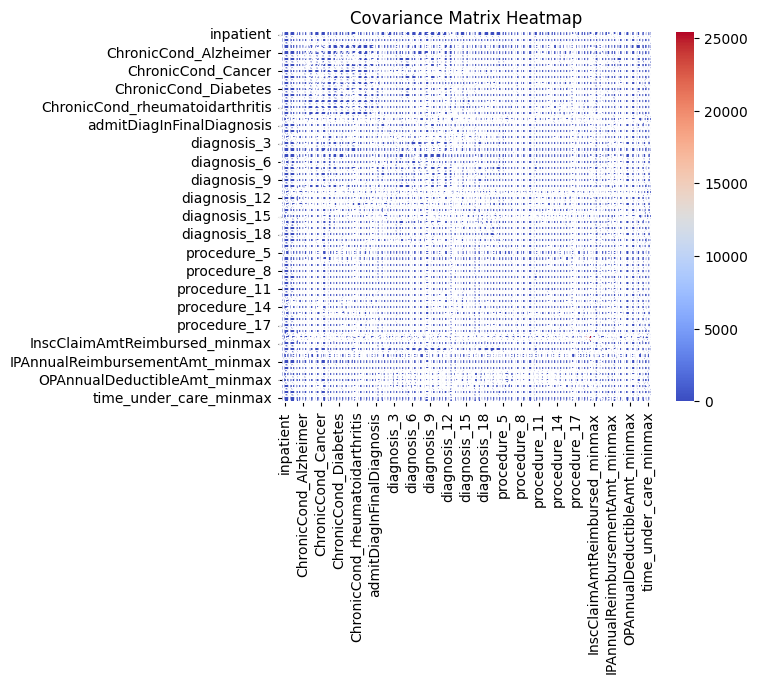

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cov_matrix = train_data.cov()

sns.heatmap(cov_matrix, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title('Covariance Matrix Heatmap')
plt.show()

In [56]:
prov_sort = pd.DataFrame(train_data['Provider_freq'].sort_values(ascending=False))

print(prov_sort)

        Provider_freq
45264        1030.000
42693        1030.000
42687        1030.000
42688        1030.000
42689        1030.000
...               ...
294516          0.125
543180          0.125
184060          0.125
552867          0.125
401867          0.125

[558211 rows x 1 columns]


[45264, 42693, 42687, 42688, 42689, 42690, 42691, 42692, 42694, 42685, 42695, 42696, 42697, 42698, 42699, 42700, 42686, 42684, 42702, 42675, 42669, 42670, 42671, 42672, 42673, 42674, 42676, 42683, 42677, 42678, 42679, 42680, 42681, 42682, 42701, 42703, 42667, 42729, 42723, 42724, 42725, 42726, 42727, 42728, 42730, 42721, 42731, 42732, 42733, 42734, 42735, 42736, 42722, 42720, 42704, 42711, 42705, 42706, 42707, 42708, 42709, 42710, 42712, 42719, 42713, 42714, 42715, 42716, 42717, 42718, 42668, 42666, 42738, 42621, 42615, 42616, 42617, 42618, 42619, 42620, 42622, 42613, 42623, 42624, 42625, 42626, 42627, 42628, 42614, 42612, 42630, 42603, 42597, 42598, 42599, 42600, 42601, 42602, 42604, 42611, 42605, 42606, 42607, 42608, 42609, 42610, 42629, 42631, 42665, 42657, 42651, 42652, 42653, 42654, 42655, 42656, 42658, 42649, 42659, 42660, 42661, 42662, 42663, 42664, 42650, 42648, 42632, 42639, 42633, 42634, 42635, 42636, 42637, 42638, 42640, 42647, 42641, 42642, 42643, 42644, 42645, 42646, 42737